# Applying Machine learning for classification

In [6]:
#Loading important libraries
import matplotlib
import pathlib
import mne
print(mne.__version__)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

0.23.0


## loading and Preparing data

Firstly we directly load the data that we had saved after the processing from the previous notebook.

In [31]:
loadfile = np.load("data1.npz")
datars = loadfile["X"]
y = loadfile["y"]
del loadfile

n_trials = total number of trials (for the subjects we are taking so far).

dims_ip = number of input dimensions for feeding into the MLP model. Note that for feeding to the MLP model, we have to flatten the 351 X 61 to 21411.

dims_lstm_1 and dims_lstm_2 are just used for feeding the data into the lstm and cnn models.

In [32]:
print(datars.shape)

n_trials = datars.shape[0]
dims_lstm_1 = datars.shape[1]
dims_lstm_2 = datars.shape[2]


datars_flattened = datars.reshape(n_trials, -1)
print(datars_flattened.shape)

dims_ip = datars_flattened.shape[1]
dims_ip


(1875, 351, 61)
(1875, 21411)


21411

Just reshaping y from (num_samples, ) to (num_samples, 1) and then concatenating x (stored in datars currently) and y with axis = 1 so that we can remove the error samples (explained thoroughly just below).

In [33]:
#Preparing main dataset
y = y.reshape(-1, 1)
# y = y[...,np.newaxis]
datarscopy = datars.copy()
datarscopy = datarscopy.reshape(datars.shape[0], -1)

print(datars.shape)
print(y.shape)
main_dataset = np.concatenate((datarscopy, y), axis = 1)
print(main_dataset.shape)

#Defining main x and y for training
main_x = main_dataset[:, :-1]
main_y = main_dataset[:, -1]
print(main_x.shape)
print(main_y.shape)

(1875, 351, 61)
(1875, 1)
(1875, 21412)
(1875, 21411)
(1875,)


## Classfying go/no/cue/button press

The dataset variable is just a copy of main_dataset with the difference now that we are removing all the error labelled samples. There are various kind of errors that our subjects exhibit like not pressing the buttong when they are supposed to or pressing them when they are not supposed to.

Then furthur we are creating the (xmlp, ymlp), (xcnn, ycnn) and (xlstm, ylstm) by copying from the x and y that we have obtained after removing the error samples from the dataset. We also have to reshape the xcnn and xlstm so as to be able to fit them into the corresponding models.

In [34]:
#Removing events which are not needed for current task
dataset = main_dataset.copy()
print(dataset.shape)
dataset = dataset[dataset[:, -1]!=9]
dataset = dataset[dataset[:, -1]!=10]

dataset = dataset[dataset[:, -1]!=3]
dataset = dataset[dataset[:, -1]!=6]
dataset = dataset[dataset[:, -1]!=7]
dataset = dataset[dataset[:, -1]!=8]
dataset = dataset[dataset[:, -1]!=11]

print(dataset.shape)

#Defining x and y
x = dataset[:, :-1]
y = dataset[:, -1]
print(x.shape)
print(y.shape)
print(list(set(y)))

permutations = np.random.permutation(len(x))
# print(permutation)
print(x[-1])
x = x[permutations]
y = y[permutations]
print(x[-1])

xmlp = x.copy()
ymlp = y.copy()

xlstm = x.copy().reshape((-1, dims_lstm_1, dims_lstm_2))
ylstm = y.copy()

xcnn = x.copy().reshape((-1, dims_lstm_1, dims_lstm_2))
ycnn = y.copy()

(1875, 21412)
(1123, 21412)
(1123, 21411)
(1123,)
[1.0, 2.0, 4.0, 5.0]
[-1.36049910e-05 -1.44154366e-05 -8.69092783e-06 ... -2.58918331e-06
 -2.30705942e-06 -2.82092341e-06]
[-1.77927571e-06 -5.17783191e-06  2.93138131e-06 ... -3.21424524e-06
 -2.26378243e-06 -2.96674828e-06]


Now we are just changing the cue, go, no-go and button-press to 0, 1, 2 and 3 so that we can now properly apply One-hot encoding. Also printing list(set(y)) for checking if we only now have the labels that we need.

In [35]:
#Encoding y
dict = {1.0: 0,2.0: 1, 4.0: 2, 5.0: 3}

for i in range(len(y)):
    y[i] = dict[y[i]]
    ylstm[i] = dict[ylstm[i]]

print(list(set(y)))

[0.0, 1.0, 2.0, 3.0]


Now we apply the one-hot encoding to the new labels and hence successfully creating ymlp, ycnn and ylstm.

In [36]:
import tensorflow as tf

num_classes = 4
y = tf.keras.utils.to_categorical(y, num_classes)
ymlp = y.copy()
ylstm = y.copy()
ycnn = y.copy()
# yab10_1[0]
print(y[:10])

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


We just take the 1st 80% of the sample for training data and the later 20% for testing data.

In [37]:
train_test_split = int(0.8 * len(xmlp))
print(train_test_split)

x_train_mlp = xmlp[:train_test_split]
y_train_mlp = ymlp[:train_test_split]

x_test_mlp = xmlp[train_test_split:]
y_test_mlp = ymlp[train_test_split:]

# x_mlp_train = xmlp[:]

898


The function get_cyclic_generator takes the whole X and Y as the input and then creates batches of any size (default value = 1). Since it is a cyclic generator, it does not stop itself and we have to set an additional parameter steps_per_epoch other than epochs. 

In [38]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

For our purpose we set the train_batch_size = 32 (a common value for batch_size) for getting our train_cyclic_generator.

Currently, we are not using this train_cyclic_generator while training the model and rather just feeding the X and y directly into the model with shuffling turned on, since we have a few doubts regarding the same. 

SIR PLEASE TALK TO US REGARDING THIS ONCE SO THAT WE KNOW IF WE SHOULD USE THIS CYCLIC GENERATOR OR NOT.

In [39]:
train_batch_size = 32
train_cyclic_generator_mlp = get_cyclic_generator(x_train_mlp, y_train_mlp, batch_size = train_batch_size)
# test_cyclic_generator_mlp = get_cyclic_generator(x_test_mlp, y_test_mlp, batch_size = train_batch_size)

### Training on MLP Model

This is the first model that we have created for our classification task. This is a Multi-layer Perceptron model. It consists of 3 dense layers in total, the first 2 followed by dropout layers for avoiding overfittiing. The final layer has 4 output classes with Softmax activation for the classification task.

In [40]:
#Creating model architecture
inp_shape = (dims_ip, )
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
drop = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(drop)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp = tf.keras.Model(inputs = ip, outputs = out)
mlp.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21411)]           0         
_________________________________________________________________
dense (Dense)                (None, 32)                685184    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_______________________

We have used 2 callbacks here, The EarlyStop callback and the ModelCheckpoint callback. The min_delta value is 0.001 and any change greater than that will be considered as an improvement. We are monitoring Validation Accuracy as a measure of improvement (or opposite) and patience is set to 10.

In [41]:
# Compiling the model
mlp_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'mlp_checkpoint/checkpoint_{epoch:02d}';
mlp_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

mlp.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

We are training the model for a maximum of 100 epochs and have set the batch size equal to 32. The training data is created by taking 80% of the training data and testing data is the rest 20%.

In [42]:
mlp_history = mlp.fit(
                      x_train_mlp, 
                      y_train_mlp,
#                       train_cyclic_generator_mlp,
#                       validation_data = test_cyclic_generator_mlp,
                      validation_data = (x_test_mlp, y_test_mlp),
#                       steps_per_epoch= 449,
                      epochs = 100,
                      batch_size = 32,
                      shuffle = True
#                       callbacks = [mlp_earlystop, mlp_checkpoint],
                     ) #Fitting the model

Train on 898 samples, validate on 225 samples
Epoch 1/100
898/898 [==============================] - 1s 2ms/sample - loss: 1.3658 - acc: 0.6136 - val_loss: 1.3325 - val_acc: 0.6933
Epoch 2/100
898/898 [==============================] - 1s 882us/sample - loss: 1.3041 - acc: 0.6281 - val_loss: 1.2253 - val_acc: 0.6933
Epoch 3/100
898/898 [==============================] - 1s 901us/sample - loss: 1.1986 - acc: 0.6281 - val_loss: 1.0756 - val_acc: 0.6933
Epoch 4/100
898/898 [==============================] - 1s 635us/sample - loss: 1.1070 - acc: 0.6281 - val_loss: 0.9699 - val_acc: 0.6933
Epoch 5/100
898/898 [==============================] - 1s 636us/sample - loss: 1.0606 - acc: 0.6281 - val_loss: 0.9334 - val_acc: 0.6933
Epoch 6/100
898/898 [==============================] - 1s 678us/sample - loss: 1.0359 - acc: 0.6281 - val_loss: 0.9181 - val_acc: 0.6933
Epoch 7/100
898/898 [==============================] - 1s 590us/sample - loss: 1.0197 - acc: 0.6281 - val_loss: 0.9159 - val_acc: 0.69

KeyboardInterrupt: 

Below we have plotted the accuracy and loss curves for both training and validation. We are facing a major issue here, which is that the validation accuracy remains totally constat just after the 1st epoch itself and remains like that till the end. Also the validation acc that we are getting is the same for the MLP, CNN and LSTM models.

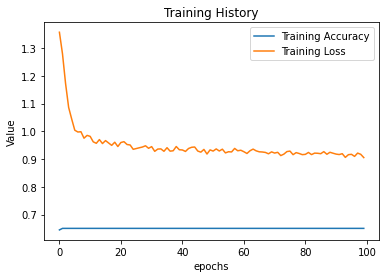

Initial training accuracy is:  0.64476615
Final training accuracy is:  0.65033406
Initial training loss is:  1.3572006753930004
Final training loss is:  0.9054617494145587


In [71]:
#Plotting model history
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", mlp_history.history['acc'][0])
print("Final training accuracy is: ", mlp_history.history['acc'][-1])

print("Initial training loss is: ", mlp_history.history['loss'][0])
print("Final training loss is: ", mlp_history.history['loss'][-1])

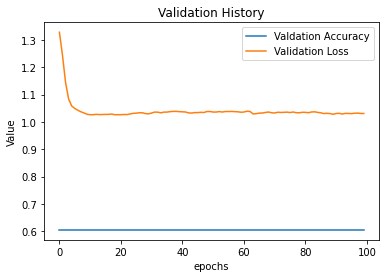

Initial validation accuracy is:  0.60444444
Final validation accuracy is:  0.60444444
Initial validation loss is:  1.328415658738878
Final validation loss is:  1.0308793210983276


In [72]:
#Plotting model history
plt.plot(mlp_history.history['val_acc'])
plt.plot(mlp_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial validation accuracy is: ", mlp_history.history['val_acc'][0])
print("Final validation accuracy is: ", mlp_history.history['val_acc'][-1])

print("Initial validation loss is: ", mlp_history.history['val_loss'][0])
print("Final validation loss is: ", mlp_history.history['val_loss'][-1])

## Training on LSTM model

Again taking 80% of the data for training purposes while the other 20% fro validation. 

In [43]:
train_test_split = int(0.8 * len(xlstm))
print(train_test_split)

x_train_lstm = xlstm[:train_test_split]
y_train_lstm = ylstm[:train_test_split]

x_test_lstm = xlstm[train_test_split:]
y_test_lstm = ylstm[train_test_split:]

898


Just the same as earlier.

SIR AGAIN PLEASE TALK TO US REGARDING THIS ONCE

In [44]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [45]:
train_batch_size = 32
train_cyclic_generator_lstm = get_cyclic_generator(x_train_lstm, y_train_lstm, batch_size = train_batch_size)
# test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

This is our 2nd architecture, which is an LSTM model. It is a very simple LSTM model with only 1 LSTM layer followed by a flatten layer then 2 intermediate dense layers and one final dense layer for classifying. We also have dropout layers in between to reduce overfitting and leakyRelu as activations.

In [46]:
#Creating model architecture
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
lstm = tf.keras.layers.LSTM(32, return_sequences=True)(ip)
# drop = tf.keras.layers.Dropout(.4)(lstm)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
# drop = tf.keras.layers.Dropout(.4)(lstm)
flatten = tf.keras.layers.Flatten()(lstm)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.4)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

lstm = tf.keras.Model(inputs = ip, outputs = out)
lstm.summary()
# inp_shape = (None, )
# review_sequence = tf.keras.Input(shape = inp_shape)
# embedding_sequence = tf.keras.layers.Embedding(input_dim=100+1, output_dim=32, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
# average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
# positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

# model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 351, 61)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 351, 32)           12032     
_________________________________________________________________
flatten (Flatten)            (None, 11232)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                359456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528 

Again the 2 callbacks are exactly the same as in case of the MLP model.

In [47]:
# Compiling the model
lstm_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'lstm_checkpoint/checkpoint_{epoch:02d}';
lstm_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

lstm.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

again we are not still using the cyclice generator function for now

In [48]:
lstm_history = lstm.fit(x_train_lstm, y_train_lstm,
                        validation_data = (x_test_lstm, y_test_lstm),
#                         steps_per_epoch= 449,
                        epochs = 100,
                        batch_size = 32,
                        callbacks = [lstm_checkpoint]) #Fitting the model

Train on 898 samples, validate on 225 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
896/898 [============================>.] - ETA: 0s - loss: 1.1415 - acc: 0.5926
Epoch 00001: val_acc improved from -inf to 0.69333, saving model to lstm_checkpoint/checkpoint_01
898/898 [==============================] - 24s 26ms/sample - loss: 1.1422 - acc: 0.5924 - val_loss: 0.9747 - val_acc: 0.6933
Epoch 2/100
896/898 [============================>.] - ETA: 0s - loss: 1.0516 - acc: 0.5871
Epoch 00002: val_acc did not improve from 0.69333
898/898 [==============================] - 21s 23ms/sample - loss: 1.0522 - acc: 0.5869 - val_loss: 0.9065 - val_acc: 0.6933
Epoch 3/100
544/898 [=================>............] - ETA: 7s - loss: 1.0570 - acc: 0.6085

KeyboardInterrupt: 

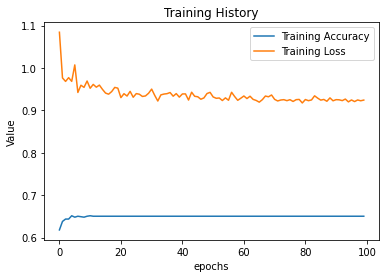

Initial training accuracy is:  0.6180401
Final training accuracy is:  0.65033406
Initial training loss is:  1.0844334687846806
Final training loss is:  0.9243905087621812


In [82]:
#Plotting model history
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", lstm_history.history['acc'][0])
print("Final training accuracy is: ", lstm_history.history['acc'][-1])

print("Initial training loss is: ", lstm_history.history['loss'][0])
print("Final training loss is: ", lstm_history.history['loss'][-1])

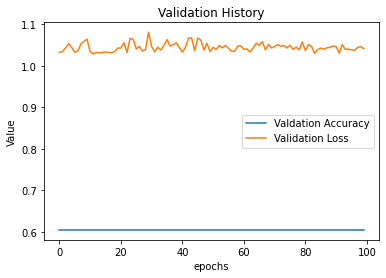

Initial Validation accuracy is:  0.60444444
Final Validation accuracy is:  0.60444444
Initial Validation loss is:  1.0323702801598442
Final Validation loss is:  1.0413138622707792


In [83]:
#Plotting model history
plt.plot(lstm_history.history['val_acc'])
plt.plot(lstm_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", lstm_history.history['val_acc'][0])
print("Final Validation accuracy is: ", lstm_history.history['val_acc'][-1])

print("Initial Validation loss is: ", lstm_history.history['val_loss'][0])
print("Final Validation loss is: ", lstm_history.history['val_loss'][-1])

### Training on CNN Model

Everything same as for LSTM and MLP. So no additional comments for this section

In [53]:
train_test_split = int(0.8 * len(xcnn))
print(train_test_split)

x_train_cnn = xcnn[:train_test_split]
y_train_cnn = ycnn[:train_test_split]

x_test_cnn = xcnn[train_test_split:]
y_test_cnn = ycnn[train_test_split:]

898


In [54]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [55]:
train_batch_size = 32
train_cyclic_generator_cnn = get_cyclic_generator(x_train_cnn, y_train_cnn, batch_size = train_batch_size)
# test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

In [56]:
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3,)(ip)
rel = tf.keras.layers.LeakyReLU()(conv1)
conv2 = tf.keras.layers.Conv1D(16, 3,)(rel)
rel2 = tf.keras.layers.LeakyReLU()(conv2)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(rel2)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.4)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

cnn = tf.keras.Model(inputs = ip, outputs = out)
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 351, 61)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 349, 32)           5888      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 349, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 347, 16)           1552      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 347, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5552)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1776

In [57]:
# Compiling the model
cnn_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'cnn_checkpoint/checkpoint_{epoch:02d}';
cnn_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

cnn.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [89]:
cnn_history = cnn.fit(x_train_cnn, y_train_cnn,
                        validation_data = (x_test_cnn, y_test_cnn),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [cnn_checkpoint]) #Fitting the model

Train on 898 samples, validate on 225 samples
Epoch 1/100
896/898 [============================>.] - ETA: 0s - loss: 1.1360 - acc: 0.5804- ETA: 0s - loss: 1.1601 - acc: 0
Epoch 00001: val_acc improved from -inf to 0.60444, saving model to cnn_checkpoint/checkpoint_01
898/898 [==============================] - 5s 5ms/sample - loss: 1.1374 - acc: 0.5802 - val_loss: 1.0319 - val_acc: 0.6044
Epoch 2/100
896/898 [============================>.] - ETA: 0s - loss: 1.0115 - acc: 0.6306
Epoch 00002: val_acc did not improve from 0.60444
898/898 [==============================] - 2s 2ms/sample - loss: 1.0108 - acc: 0.6314 - val_loss: 1.0259 - val_acc: 0.6044
Epoch 3/100
896/898 [============================>.] - ETA: 0s - loss: 0.9897 - acc: 0.6373- ETA: 1s - loss: 0.9832 - ETA: 0s - loss: 0.9885 - acc: 0
Epoch 00003: val_acc did not improve from 0.60444
898/898 [==============================] - 2s 2ms/sample - loss: 0.9887 - acc: 0.6381 - val_loss: 1.0229 - val_acc: 0.6044
Epoch 4/100
896/898 [

In [90]:
# #Plotting model history
# plt.plot(cnn_history.history['acc'])
# plt.plot(cnn_history.history['loss'])
# plt.legend(['Training Accuracy', 'Training Loss'])
# plt.title('Training History')
# plt.ylabel('Value')
# plt.xlabel('epochs')
# plt.show()
# print("Initial training accuracy is: ", cnn_history.history['acc'][0])
# print("Final training accuracy is: ", cnn_history.history['acc'][-1])

# print("Initial training loss is: ", cnn_history.history['loss'][0])
# print("Final training loss is: ", cnn_history.history['loss'][-1])

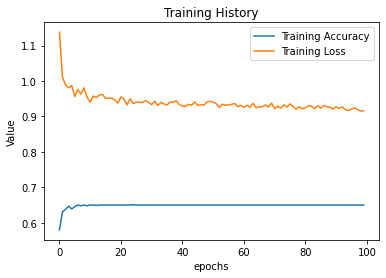

Initial training accuracy with preprocessing is:  0.5801782
Final training accuracy with preprocessing is:  0.65033406
Initial training loss with preprocessing is:  1.1374031578777628
Final training loss with preprocessing is:  0.9161267303809822


In [91]:
#Plotting model history
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')..........,,,,,,,,,,,,,,,,,

plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", cnn_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", cnn_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", cnn_history.history['loss'][0])
print("Final training loss with preprocessing is: ", cnn_history.history['loss'][-1])

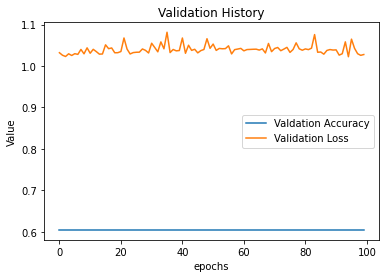

Initial Validation accuracy with preprocessing is:  0.60444444
Final Validation accuracy with preprocessing is:  0.60444444
Initial Validation loss with preprocessing is:  1.0319379064771863
Final Validation loss with preprocessing is:  1.0276036643981934


In [92]:
#Plotting model history
plt.plot(cnn_history.history['val_acc'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", cnn_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", cnn_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", cnn_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", cnn_history.history['val_loss'][-1])

In [93]:
# #Plotting model history
# plt.plot(cnn_history.history['val_acc'])
# plt.plot(cnn_history.history['val_loss'])
# plt.legend(['Valdation Accuracy', 'Validation Loss'])
# plt.title('Validation History')
# plt.ylabel('Value')
# plt.xlabel('epochs')
# plt.show()
# print("Initial Validation accuracy is: ", cnn_history.history['val_acc'][0])
# print("Final Validation accuracy is: ", cnn_history.history['val_acc'][-1])

# print("Initial Validation loss is: ", cnn_history.history['val_loss'][0])
# print("Final Validation loss is: ", cnn_history.history['val_loss'][-1])

### Feature Extraction Model

In [58]:
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3,)(ip)
# rel1 = tf.keras.layers.LeakyReLU()(conv1)
maxpool1 = tf.keras.layers.MaxPooling1D()(conv1)
skip1 = maxpool1
conv2 = tf.keras.layers.Conv1D(32, 3,)(maxpool1)
conv2 = tf.keras.layers.ZeroPadding1D(padding=1)(conv2)
# rel2 = tf.keras.layers.LeakyReLU()(conv2)
maxpool2 = tf.keras.layers.MaxPooling1D()(conv2)
maxpool2 = tf.keras.layers.ZeroPadding1D(padding=(44,43))(maxpool2)
skip2 = maxpool2
conv3 = tf.keras.layers.Conv1D(32, 3,)(maxpool2)
conv3 = tf.keras.layers.ZeroPadding1D(padding=1)(conv3)
conv4 = tf.keras.layers.Conv1D(32, 3,)(conv3)
conv4 = tf.keras.layers.ZeroPadding1D(padding=1)(conv4)
conv5 = tf.keras.layers.Conv1D(32, 3,)(conv4)
conv5 = tf.keras.layers.ZeroPadding1D(padding=1)(conv5)
maxpool5 = tf.keras.layers.MaxPooling1D()(conv5)
maxpool5 = tf.keras.layers.ZeroPadding1D(padding=(44, 43))(maxpool5)
addlayer1 = tf.keras.layers.Add()([skip1, skip2, maxpool5])

# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(addlayer1)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
# leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
# drop1 = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(dense1)
# leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

ftExtract = tf.keras.Model(inputs = ip, outputs = out)
ftExtract.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 351, 61)]    0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 349, 32)      5888        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 174, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 172, 32)      3104        max_pooling1d[0][0]              
____________________________________________________________________________________________

In [103]:
# Compiling the model
fte_earlystop = EarlyStopping(patience = 15, min_delta = 0.001, monitor = 'val_acc')

path = 'fte_checkpoint/checkpoint_{epoch:02d}';
fte_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

ftExtract.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [96]:
ftExtract_history = ftExtract.fit(x_train_cnn, y_train_cnn,
                        validation_data = (x_test_cnn, y_test_cnn),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [fte_checkpoint],
                    ) #Fitting the model

Train on 898 samples, validate on 225 samples
Epoch 1/100
896/898 [============================>.] - ETA: 0s - loss: 1.0414 - acc: 0.6440
Epoch 00001: val_acc improved from -inf to 0.60444, saving model to fte_checkpoint/checkpoint_01
898/898 [==============================] - 5s 6ms/sample - loss: 1.0446 - acc: 0.6425 - val_loss: 1.0317 - val_acc: 0.6044
Epoch 2/100
896/898 [============================>.] - ETA: 0s - loss: 0.9814 - acc: 0.6328
Epoch 00002: val_acc did not improve from 0.60444
898/898 [==============================] - 3s 4ms/sample - loss: 0.9800 - acc: 0.6336 - val_loss: 1.0509 - val_acc: 0.6044
Epoch 3/100
896/898 [============================>.] - ETA: 0s - loss: 0.9534 - acc: 0.6507
Epoch 00003: val_acc did not improve from 0.60444
898/898 [==============================] - 3s 3ms/sample - loss: 0.9538 - acc: 0.6503 - val_loss: 1.0356 - val_acc: 0.6044
Epoch 4/100
896/898 [============================>.] - ETA: 0s - loss: 0.9638 - acc: 0.6507
Epoch 00004: val_acc

In [101]:
tf.keras.utils.plot_model(ftExtract)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


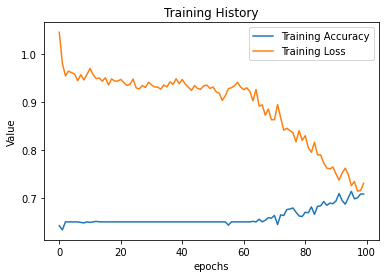

Initial training accuracy with preprocessing is:  0.64253896
Final training accuracy with preprocessing is:  0.7082405
Initial training loss with preprocessing is:  1.0446460108980038
Final training loss with preprocessing is:  0.7305026109473477


In [100]:
#Plotting model history
plt.plot(ftExtract_history.history['acc'])
plt.plot(ftExtract_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", ftExtract_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", ftExtract_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", ftExtract_history.history['loss'][0])
print("Final training loss with preprocessing is: ", ftExtract_history.history['loss'][-1])

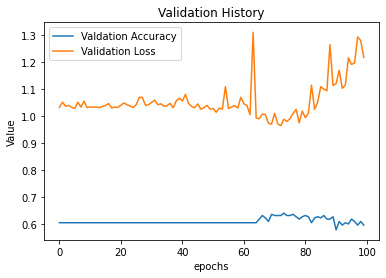

Initial Validation accuracy with preprocessing is:  0.60444444
Final Validation accuracy with preprocessing is:  0.59555554
Initial Validation loss with preprocessing is:  1.0316880893707276
Final Validation loss with preprocessing is:  1.2166440386242336


In [99]:
#Plotting model history
plt.plot(ftExtract_history.history['val_acc'])
plt.plot(ftExtract_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][-1])

## Training for go/no-go

Everything below is same as above just now we have 2 classes only, go and no-go.

In [ ]:
#Creating dataset
datasetgonogo = main_dataset.copy()
print(datasetgonogo.shape)

unwanted_events_gonogo = [9, 10, 3, 6, 7, 8, 11, 1, 5]

for e in unwanted_events_gonogo:
    datasetgonogo = datasetgonogo[datasetgonogo[:, -1]!=e]

print(datasetgonogo.shape)

xgonogo = datasetgonogo[:, :-1]
ygonogo = datasetgonogo[:, -1]
print(xgonogo.shape)
print(ygonogo.shape)
print(list(set(ygonogo)))

permutations = np.random.permutation(len(xgonogo))
xgonogo = xgonogo[permutations]
ygonogo = ygonogo[permutations]

(1875, 21412)
(600, 21412)
(600, 21411)
(600,)
[2.0, 4.0]


In [ ]:
#Encoding y
dict = {2.0: 0, 4.0: 1}

for i in range(len(ygonogo)):
    ygonogo[i] = dict[ygonogo[i]]

print(list(set(ygonogo)))

[0.0, 1.0]


In [ ]:
num_classes = 2
ygonogo = tf.keras.utils.to_categorical(ygonogo, num_classes)
ygonogo[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
train_test_split = int(0.8 * len(xgonogo))
print(train_test_split)

xgonogo_train_mlp = xgonogo[:train_test_split]
ygonogo_train_mlp = ygonogo[:train_test_split]

xgonogo_test_mlp = xgonogo[train_test_split:]
ygonogo_test_mlp = ygonogo[train_test_split:]

xgonogo_train_mlp.shape

480


(480, 21411)

In [ ]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [ ]:
train_batch_size = 32
train_cyclic_generator_mlp_gonogo = get_cyclic_generator(xgonogo_train_mlp, ygonogo_train_mlp, batch_size = train_batch_size)
# test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

In [ ]:
#Creating model architecture
inp_shape = (dims_ip, )
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
drop = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(drop)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp_gonogo = tf.keras.Model(inputs = ip, outputs = out)
mlp_gonogo.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 21411)]           0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                685184    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 34        
Total params: 685,746
Trainable params: 685,746
Non-trainable params: 0
_____________________________________________________

In [ ]:
# Compiling the model
mlp_gonogo_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'mlp_gonogo_checkpoint/checkpoint_{epoch:02d}';
mlp_gonogo_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

mlp_gonogo.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [ ]:
# historygonogo = modelgonogo.fit(xgonogo, ygonogo, epochs=300, callbacks = [earlystop, model_checkpoint]) #plotting the model

mlp_gonogo_history = mlp_gonogo.fit(train_cyclic_generator_mlp_gonogo,
                        validation_data = (xgonogo_test_mlp, ygonogo_test_mlp),
                        steps_per_epoch= 449,
                        epochs = 50,
                        callbacks = [mlp_gonogo_earlystop, mlp_gonogo_checkpoint]) #Fitting the model

  ...
    to  
  ['...']
Train for 449 steps, validate on 120 samples
Epoch 1/50
447/449 [============================>.] - ETA: 0s - loss: 0.5398 - acc: 0.7902
Epoch 00001: val_acc improved from -inf to 0.83333, saving model to mlp_gonogo_checkpoint/checkpoint_01
449/449 [==============================] - 8s 17ms/step - loss: 0.5393 - acc: 0.7906 - val_loss: 0.4597 - val_acc: 0.8333
Epoch 2/50
446/449 [============================>.] - ETA: 0s - loss: 0.5156 - acc: 0.7922
Epoch 00002: val_acc did not improve from 0.83333
449/449 [==============================] - 6s 13ms/step - loss: 0.5161 - acc: 0.7918 - val_loss: 0.4561 - val_acc: 0.8333
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 0.5159 - acc: 0.7911
Epoch 00003: val_acc did not improve from 0.83333
449/449 [==============================] - 6s 14ms/step - loss: 0.5155 - acc: 0.7914 - val_loss: 0.4582 - val_acc: 0.8333
Epoch 4/50
445/449 [============================>.] - ETA: 0s - loss: 0.5118 - acc: 0.7

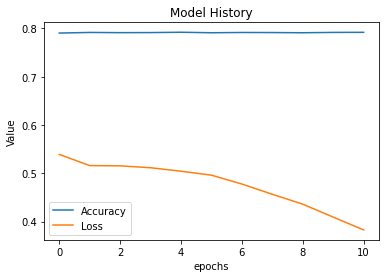

Initial accuracy is:  0.7905763
Final accuracy is:  0.79210746
Initial loss is:  0.5392751983783823
Final loss is:  0.3828980540711524


In [ ]:
#plotting model history
plt.plot(mlp_gonogo_history.history['acc'])
plt.plot(mlp_gonogo_history.history['loss'])
plt.legend(['Accuracy', 'Loss'])
plt.title('Model History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial accuracy is: ", mlp_gonogo_history.history['acc'][0])
print("Final accuracy is: ", mlp_gonogo_history.history['acc'][-1])

print("Initial loss is: ", mlp_gonogo_history.history['loss'][0])
print("Final loss is: ", mlp_gonogo_history.history['loss'][-1])

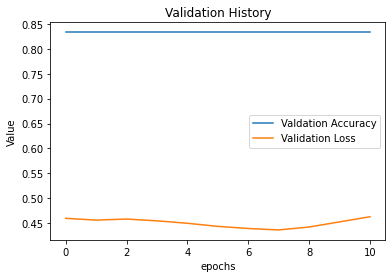

Initial Validation accuracy is:  0.8333333
Final Validation accuracy is:  0.8333333
Initial Validation loss is:  0.4596542636553446
Final Validation loss is:  0.4628682096799215


In [ ]:
#Plotting model history
plt.plot(mlp_gonogo_history.history['val_acc'])
plt.plot(mlp_gonogo_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", mlp_gonogo_history.history['val_acc'][0])
print("Final Validation accuracy is: ", mlp_gonogo_history.history['val_acc'][-1])

print("Initial Validation loss is: ", mlp_gonogo_history.history['val_loss'][0])
print("Final Validation loss is: ", mlp_gonogo_history.history['val_loss'][-1])

In [ ]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

1
